In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision.transforms import ToTensor

plt.rcParams['figure.figsize'] = (8, 8)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io
from PIL import Image
from torchvision import transforms


class Number16(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        
        img_path_new = img_path.split(';')[0]
        image = Image.open(img_path_new).convert('L')  # Convert to grayscale upon loading
        y_label = torch.tensor(int(img_path.split(';')[1]))
        #print(y_label)

        if self.transform:
            image = self.transform(image)

        return (image, y_label)


dataset = Number16(
    # csv_file="/content/drive/MyDrive/num16_f.csv",                 # adamov root
    # root_dir="/content/drive/MyDrive/num16",
    csv_file="num16_f.csv",                    #alexov root
    root_dir="num16",
    #transform=transforms.ToTensor(),
    # Define the transformations: Convert to grayscale, resize, then convert to tensor
    transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    # transforms.RandomHorizontalFlip(p=0.5)
    # transforms.RandomRotation(degrees=(0, 360) ,fill=(255,)),  # Randomly rotate between 0 and 360 degrees + fill bg with white(255)/black (0)
    # transforms.RandomRotation(degrees=(0, 360) ) , # Randomly rotate between 0 and 360 degrees
    transforms.ToTensor()  # Convert the image to a tensor
    # transforms.ToPILImage()
    # https://www.youtube.com/watch?v=Zvd276j9sZ8&ab_channel=AladdinPersson
    ])
)
print("Number of images in dataset: ",len(dataset))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

loaders = {
    'train' : torch.utils.data.DataLoader(train_dataset,
                                          batch_size=256,
                                          shuffle=True),

    'test'  : torch.utils.data.DataLoader(test_dataset,
                                          batch_size=64,
                                          shuffle=True)
}



Number of images in dataset:  3840


In [6]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=4,      # 127
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2,padding=0,stride=2),   # 63.5  

        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 4,stride=1,padding=1),   # 62.5
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,padding=0,stride=2), # 31.25

        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 4,stride=1,padding=1),  # 30.25
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2,padding=0,stride=2),  # 15.125

        )
        # fully connected layer, output 16 classes

        self.fc1 = nn.Sequential(
            nn.Linear(64 * 15 * 15, 512),
            nn.ReLU()
        )

        self.dropout = nn.Dropout(0.5)

        self.out =  nn.Sequential(
            nn.Linear(512, 16),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.dropout
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        output = self.out(x)
        return output, x

In [7]:
cnn = CNN()
print(cnn)
cnn.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=14400, out_features=512, bias=True)
    (1): ReLU()
  )
  (dropout): Dropo

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=14400, out_features=512, bias=True)
    (1): ReLU()
  )
  (dropout): Dropo

In [8]:
loss_func = nn.CrossEntropyLoss()

In [9]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.001, weight_decay = 0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.001
)

In [10]:
from torch.autograd import Variable
import time

num_epochs = 400
loss_iter=[]

def train(num_epochs, cnn, loaders):

    cnn.train()

    # Train the model
    total_step = len(loaders['train'])
    losses = []
    accuracies = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            # b_x = Variable(images)   # batch x
            # b_y = Variable(labels)   # batch y


            b_x = images.to(device=device)        #data
            b_y = labels.to(device=device)    #target/label

            output = cnn(b_x)[0]

            loss = loss_func(output, b_y)


            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            #  Calculate 'running' training accuracy
            features = b_x.reshape(b_x.shape[0], -1)
            img_grid = torchvision.utils.make_grid(b_x)
            _, predictions = output.max(1)
            num_correct = (predictions == b_y).sum()
            running_train_acc = float(num_correct) / float(b_x.shape[0])
            accuracies.append(running_train_acc)
            losses.append(loss.item())

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                print (f'accurancy {running_train_acc}')
            pass

        pass
    return losses, accuracies
    pass

losses=[]
start_time = time.time()

losses, accuracies = train(num_epochs, cnn, loaders)

end_time = time.time()
total_time = end_time - start_time
print(f"Trénovanie trvalo {int(total_time / 60)} minút, {total_time % 60} sekund.")

Epoch [1/400], Step [10/12], Loss: 2.6331
accurancy 0.2265625
Epoch [2/400], Step [10/12], Loss: 2.5233
accurancy 0.3515625
Epoch [3/400], Step [10/12], Loss: 2.3991
accurancy 0.47265625
Epoch [4/400], Step [10/12], Loss: 2.4014
accurancy 0.47265625
Epoch [5/400], Step [10/12], Loss: 2.3536
accurancy 0.52734375
Epoch [6/400], Step [10/12], Loss: 2.3573
accurancy 0.5234375
Epoch [7/400], Step [10/12], Loss: 2.2826
accurancy 0.59765625
Epoch [8/400], Step [10/12], Loss: 2.2800
accurancy 0.5859375
Epoch [9/400], Step [10/12], Loss: 2.2328
accurancy 0.64453125
Epoch [10/400], Step [10/12], Loss: 2.1804
accurancy 0.69140625
Epoch [11/400], Step [10/12], Loss: 2.0778
accurancy 0.8046875
Epoch [12/400], Step [10/12], Loss: 2.0684
accurancy 0.8125
Epoch [13/400], Step [10/12], Loss: 2.0486
accurancy 0.828125
Epoch [14/400], Step [10/12], Loss: 2.0291
accurancy 0.84375
Epoch [15/400], Step [10/12], Loss: 2.0074
accurancy 0.87109375
Epoch [16/400], Step [10/12], Loss: 2.0242
accurancy 0.85546875

In [11]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():

        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images.to(device=device))
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels.to(device=device)).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy )
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.91


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns  # Seaborn pre lepšie vizualizácie

def test(cnn, loaders, device):
    cnn.eval()
    all_pred_y = []
    all_true_y = []

    with torch.no_grad():
        for images, labels in loaders['test']:
            images, labels = images.to(device), labels.to(device)
            test_output, _ = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data
            all_pred_y.extend(pred_y.cpu().numpy())
            all_true_y.extend(labels.cpu().numpy())

    # Výpočet celkovej presnosti
    accuracy = np.mean(np.array(all_pred_y) == np.array(all_true_y))
    print('Test Accuracy of the model on the test images: %.2f' % (accuracy * 100))

    # Výpočet confusion matrix
    conf_matrix = confusion_matrix(all_true_y, all_pred_y)
    # Vykreslenie confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    leng=len(loaders['test'].dataset)
    print("lenght of images: ",leng)
    check=np.sum(np.array(all_pred_y) == np.array(all_true_y))
    print(f'Pred: {check}, percentil check: { 100*(check/leng) }')

# Predpokladáme, že máte definované cnn, loaders a device


test(cnn, loaders, device)  # Volanie funkcie test

NameError: name 'cnn' is not defined

Prediction number: [14  5  9 13  0  9 15  2 10  1]
Actual     number: [14  5  9 13  0  9 15  2 10  1]
Number of matching elements: 10


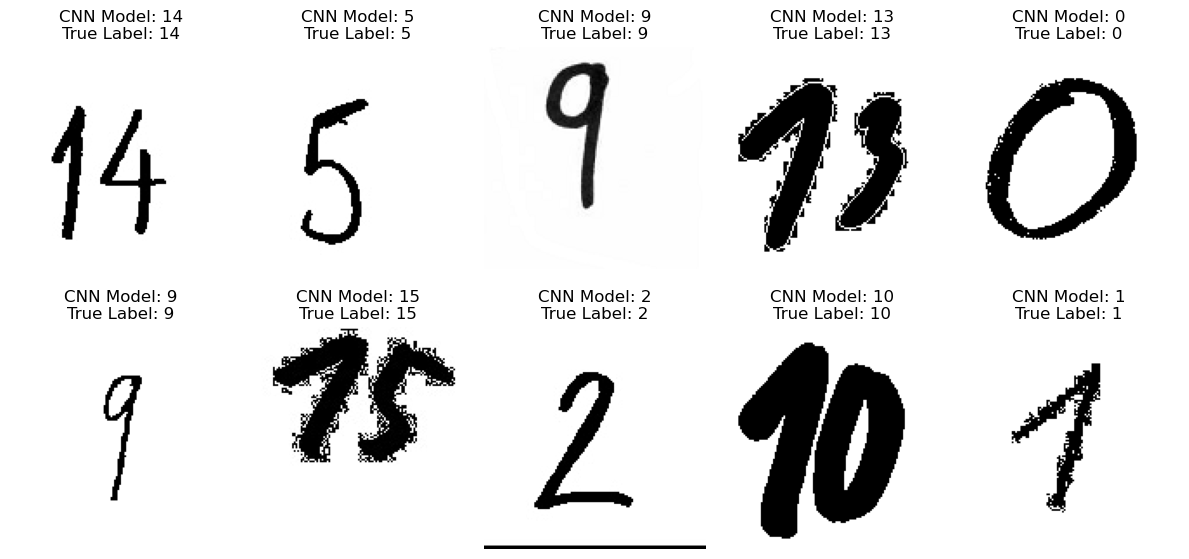

In [12]:
sample = next(iter(loaders['test']))
imgs, lbls = sample
# ...

actual_number = lbls[:10].numpy()
#actual_number

test_output, last_layer = cnn(imgs[:10].to(device=device))
pred_y = torch.max(test_output, 1)[1].cpu().data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual     number: {actual_number}')
# Porovnáme elementárne hodnoty
matches = pred_y == actual_number
# Počet zhôd
num_matches = matches.sum().item()
print(f'Number of matching elements: {num_matches}')


# Vykreslenie obrázkov a titulok s predikciou a správnym labelom
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # 2 riadky, 5 stlpcov pre 10 obrázkov
axes = axes.ravel()

for i in range(10):
    img = imgs[i].cpu().squeeze()  # Predpokladá sa, že obrázky sú na zariadení CUDA a majú jeden kanál (grayscale)
    pred_label = pred_y[i]
    true_label = actual_number[i]

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'CNN Model: {pred_label}\nTrue Label: {true_label}')
    axes[i].axis('off')  # Vypnutie osí pre čistejšie zobrazenie

plt.tight_layout()
plt.show()